In [218]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import time
import numpy as np
import cv2
from PIL import Image
import os
from matplotlib import pyplot as plt

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Define Image Dataset structure and image transform

In [219]:
IMG_SIZE = 224

class ImageDataSet(Dataset):
    def __init__(self, t_cells, tumors, transform):
        self.file_names = t_cells + tumors
        self.labels = [1]*len(t_cells) + [0]*len(tumors)
        self.transform = transform

    def __getitem__(self, index):
        img_name = self.file_names[index]
        img = Image.open(img_name).convert('RGB')
        img = self.transform(img)
        label = self.labels[index]
        return img, label
    
    def __len__(self):
        return len(self.file_names)

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Offically used by Pytorch
])

t_cells = []
invasive_tumors = []

for (dir_path, dir_names, file_names) in os.walk('100'):
    parent_folder = os.path.basename(dir_path)
    if parent_folder in ["CD4+_T_Cells", "Invasive_Tumor"]:
        for file in file_names:
            image = cv2.imread(os.path.join(dir_path, file))
            if image.shape[0] < 100 and image.shape[1] < 100: #skip the small image, it doesn't give much info
                continue
            if parent_folder == "CD4+_T_Cells":
                t_cells.append(os.path.join(dir_path, file))
            elif parent_folder == "Invasive_Tumor":
                invasive_tumors.append(os.path.join(dir_path, file))
    
dataset = ImageDataSet(t_cells, invasive_tumors, transform)

### Define the (pre-trained) CNN model

In [220]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #check if the computer has GPU

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes: Tumor and Immune
model = model.to(device)

c:\Users\brian\Desktop\A2\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\brian\Desktop\A2\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Define the training configurations

In [221]:
num_epochs = 100
patience = 10 #for early stopping
batch_size = 32
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Split training, validation, and testing sets (70% 15% 15%)

In [222]:
train_idx, temp_idx = train_test_split(list(range(len(dataset))), test_size=0.3, random_state=0)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=0)

train_subset = Subset(dataset, train_idx)
val_subset = Subset(dataset, val_idx)
test_subset = Subset(dataset, test_idx)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

### Start training CNN

In [223]:
best_val_loss = float('inf')
epoch_no_improvement = 0
best_model_parameters = None


cnn_training_start = time.time()
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss/len(val_loader)
    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_parameters = model.state_dict()
        epoch_no_improvement = 0
    else:
        epoch_no_improvement += 1
        if epoch_no_improvement == patience:
            print(f"No improvement for {patience} epoches. Early stopping.")
            break
cnn_training_end = time.time()

if best_model_parameters is not None:
    model.load_state_dict(best_model_parameters)

Epoch [1/100], Loss: 0.2800
Validation Loss: 0.5509, Accuracy: 83.78%
Epoch [2/100], Loss: 0.0914
Validation Loss: 0.3667, Accuracy: 84.46%
Epoch [3/100], Loss: 0.0616
Validation Loss: 0.9323, Accuracy: 78.04%
Epoch [4/100], Loss: 0.0725
Validation Loss: 0.3752, Accuracy: 87.84%
Epoch [5/100], Loss: 0.0658
Validation Loss: 1.6700, Accuracy: 79.39%
Epoch [6/100], Loss: 0.0538
Validation Loss: 0.0653, Accuracy: 96.96%
Epoch [7/100], Loss: 0.0360
Validation Loss: 0.2857, Accuracy: 89.53%
Epoch [8/100], Loss: 0.0150
Validation Loss: 0.1728, Accuracy: 95.95%
Epoch [9/100], Loss: 0.0047
Validation Loss: 0.1107, Accuracy: 97.64%
Epoch [10/100], Loss: 0.0030
Validation Loss: 0.1172, Accuracy: 95.95%
Epoch [11/100], Loss: 0.0150
Validation Loss: 0.2198, Accuracy: 88.85%
Epoch [12/100], Loss: 0.0894
Validation Loss: 0.5475, Accuracy: 79.05%
Epoch [13/100], Loss: 0.0419
Validation Loss: 0.1507, Accuracy: 94.59%
Epoch [14/100], Loss: 0.0042
Validation Loss: 0.1617, Accuracy: 96.96%
Epoch [15/100],

### Evaluate the model performance in testing set

0.936026936026936


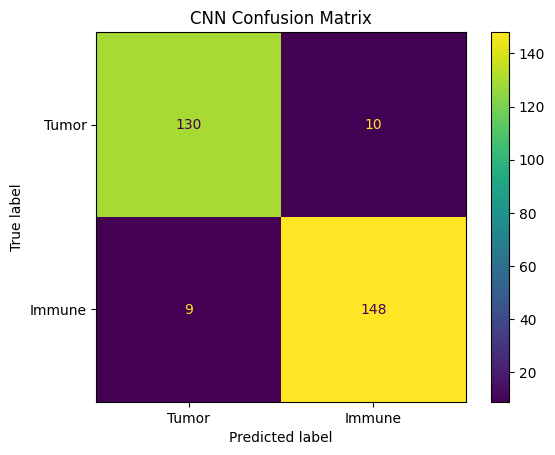

In [ ]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# print(classification_report(y_true, y_pred, target_names=["Tumor", "Immune"]))
pretrained_cnn_accuracy = accuracy_score(y_true, y_pred)
print(pretrained_cnn_accuracy)

cm = confusion_matrix(y_true, y_pred)
cnn_precision = precision_score(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Tumor", "Immune"])

cm_display.plot()
plt.title("CNN Confusion Matrix")
plt.show()

### Save the model weights

In [225]:
torch.save(model.state_dict(), 'CNN_weights.pth')

### Using the pre-trained convolutional layers to extract the features from images 

In [226]:
model.eval()
feature_extractor = nn.Sequential(*list(model.children())[:-1]) # remove the last layer
feature_extractor.eval()
feature_extractor.to(device)

train_features = []
train_labels = []
test_features = []
test_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        output = feature_extractor(images).squeeze()
        train_features.append(output.cpu().numpy())
        train_labels.append(labels.cpu().numpy())

X_train = np.vstack(train_features)
y_train = np.hstack(train_labels)

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        output = feature_extractor(images).squeeze()
        test_features.append(output.cpu().numpy())
        test_labels.append(labels.cpu().numpy())

X_test = np.vstack(test_features)
y_test = np.hstack(test_labels)

In [ ]:
svm_training_start = time.time()
svm = SVC()
svm.fit(X_train, y_train)
svm_training_end = time.time()

svm_accuracy = accuracy_score(y_test, svm.predict(X_test))

knn_accuracies = []
knn_precision = []
for k in range(1, 22, 2): #k = 1 to 21
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    knn_pred = knn.predict(X_test)
    knn_accuracies.append(accuracy_score(y_test, knn_pred))
    knn_precision.append(precision_score(y_test, knn_pred))

knn_accuracies = np.array(knn_accuracies)
max_idx = np.argmax(knn_accuracies)
best_k = 2*max_idx+1
pretrained_knn_best_accuracy = float(knn_accuracies[max_idx])
print(f"Best accuracy when k is {best_k}: {pretrained_knn_best_accuracy:.4f}")

knn_training_start = time.time()
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)
knn_training_end = time.time()

Best accuracy when k is 1: 0.9630


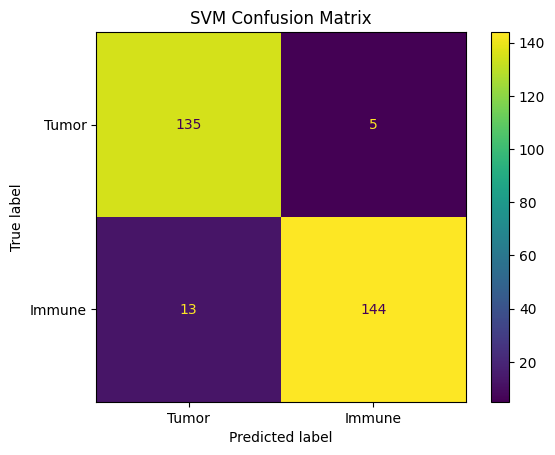

In [228]:
svm_cm = confusion_matrix(y_test, svm.predict(X_test))
svm_precision = precision_score(y_test, svm.predict(X_test))
svm_cm_display = ConfusionMatrixDisplay(confusion_matrix = svm_cm, display_labels = ["Tumor", "Immune"])

svm_cm_display.plot()
plt.title("SVM Confusion Matrix")
plt.show()

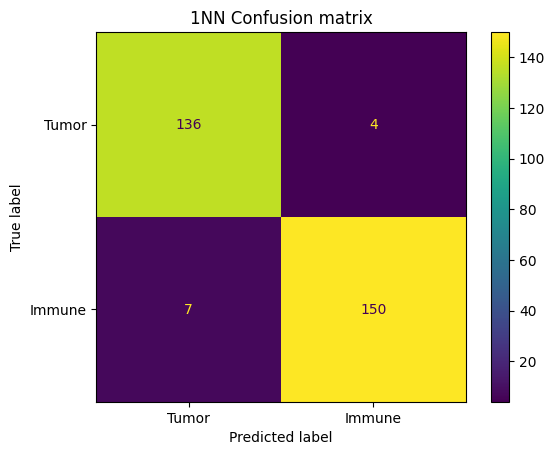

In [ ]:
knn_cm = confusion_matrix(y_test, best_knn.predict(X_test))
knn_precision = precision_score(y_test, best_knn.predict(X_test))
knn_cm_display = ConfusionMatrixDisplay(confusion_matrix = knn_cm, display_labels = ["Tumor", "Immune"])

knn_cm_display.plot()
plt.title(f"{best_k}NN Confusion matrix")
plt.show()

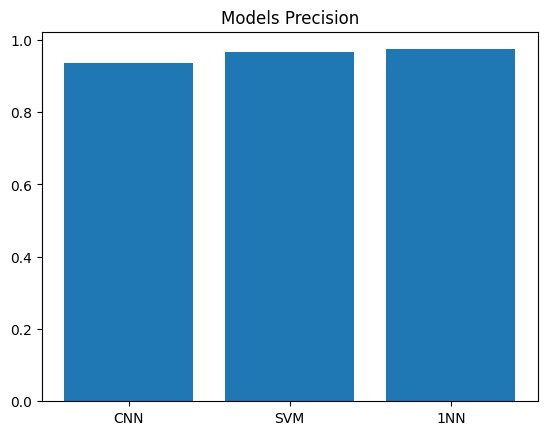

In [230]:
precisions = {"CNN": cnn_precision, "SVM": svm_precision, "1NN": knn_precision}
plt.bar(precisions.keys(), precisions.values())
plt.title("Models Precision")
plt.show()

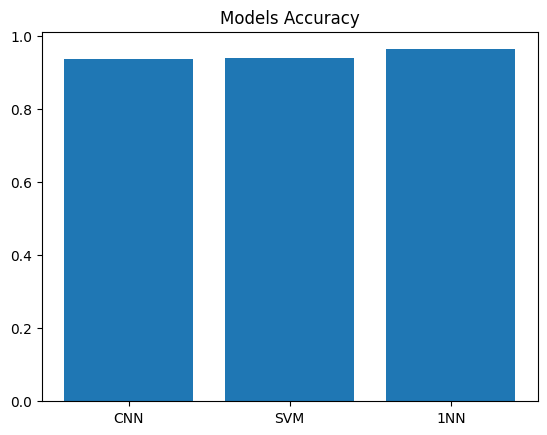

In [ ]:
accuracies = {"CNN": pretrained_cnn_accuracy, "SVM": svm_accuracy, "1NN": pretrained_knn_best_accuracy}
plt.bar(accuracies.keys(), accuracies.values())
plt.title("Models Accuracy")
plt.show()

### Training time

CNN training time: 149.14s


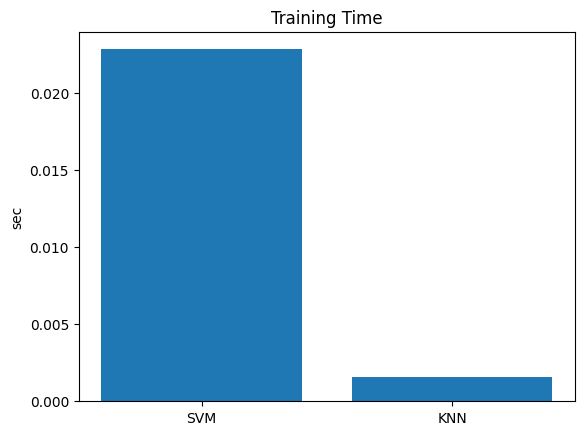

In [ ]:
print(f"CNN training time: {cnn_training_end-cnn_training_start:.2f}s") #it takes too long. the y scaling would be too large
training_times = {"SVM": svm_training_end-svm_training_start, "KNN": knn_training_end-knn_training_start}
plt.bar(training_times.keys(), training_times.values())
plt.title("Training Time")
plt.ylabel("sec")
plt.show()

### Classification time

In [235]:
model.eval()

cnn_classification_start = time.time()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
cnn_classification_end = time.time()

feature_extractor.eval()
with torch.no_grad():
    svm_classification_start = time.time()
    for images, labels in test_loader:
        images = images.to(device)
        output = feature_extractor(images).squeeze()  # shape: (batch_size, feature_dim)
        output = output.cpu().numpy()
        svm.predict(output)
    svm_classification_end = time.time()

with torch.no_grad():
    knn_classification_start = time.time()
    for images, labels in test_loader:
        images = images.to(device)
        output = feature_extractor(images).squeeze()  # shape: (batch_size, feature_dim)
        output = output.cpu().numpy()
        best_knn.predict(output)
    knn_classification_end = time.time()

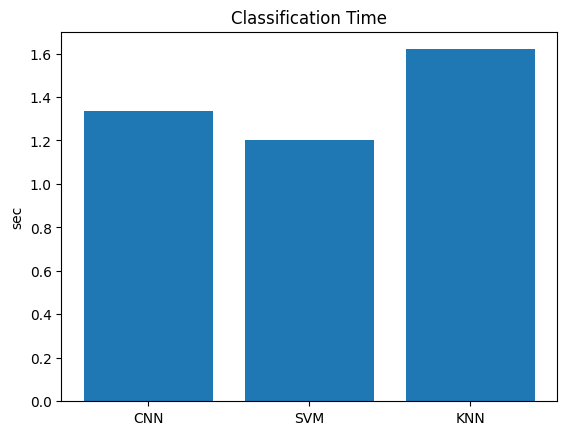

In [238]:
classification_time = {"CNN": cnn_classification_end-cnn_classification_start, "SVM": svm_classification_end-svm_classification_start, "KNN": knn_classification_end-knn_classification_start}
plt.bar(classification_time.keys(), classification_time.values())
plt.title("Classification Time")
plt.ylabel("sec")
plt.show()